In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analisis_cajas(archivo_excel, sucursal, max_cajas=10):
    """
    Analiza la cantidad de cajas recomendadas por aperturar o cerrar por hora en una sucursal,
    considerando las llegadas de los últimos 4 días de cada día de la semana.

    Parámetros:
    -----------
    archivo_excel : Ruta al archivo Excel que contiene los datos.
    sucursal : Nombre de la sucursal a analizar.
    max_cajas : Número máximo de cajas que se pueden abrir (default=10).

    Retorna:
    --------
    df_resultado_horario : DataFrame con las horas, días de la semana, promedio de llegadas y cajas sugeridas.
    """

    # Cargar datos
    df = pd.read_excel(archivo_excel)
    df['Fecha'] = pd.to_datetime(df['FechaID'].astype(str), format='%Y%m%d')
    df['Hora'] = pd.to_datetime(df['TurnoHoraInicio'], format='%H:%M:%S').dt.hour
    df['DiaSemana'] = df['Fecha'].dt.day_name()

    # Filtrar por sucursal
    if sucursal not in df['Sucursal'].unique():
        raise ValueError(f"La sucursal '{sucursal}' no se encuentra en el archivo.")

    df_sucursal = df[df['Sucursal'] == sucursal].copy()

    # Calcular capacidad por caja por hora
    capacidad_por_caja_horaria = {}
    for dia in df_sucursal['DiaSemana'].unique():
        dias_filtrados = df_sucursal[df_sucursal['DiaSemana'] == dia]
        ultimos_cuatro_dias = dias_filtrados['Fecha'].drop_duplicates().sort_values(ascending=False).head(4)
        df_dia = dias_filtrados[dias_filtrados['Fecha'].isin(ultimos_cuatro_dias)]

        df_dia['HoraCompleta'] = pd.to_datetime(df_dia['TurnoHoraInicio'], format='%H:%M:%S').dt.floor('h')
        llegadas_por_hora = df_dia.groupby(['Fecha', 'HoraCompleta']).size().reset_index(name='Llegadas')
        llegadas_por_hora['Hora'] = llegadas_por_hora['HoraCompleta'].dt.hour
        llegadas_por_hora['Cajas_usadas'] = np.ceil(llegadas_por_hora['Llegadas'] / 12)
        llegadas_por_hora['Personas_por_caja'] = llegadas_por_hora['Llegadas'] / llegadas_por_hora['Cajas_usadas']
        promedio_por_hora = llegadas_por_hora.groupby('Hora')['Personas_por_caja'].mean().to_dict()
        capacidad_por_caja_horaria[dia] = promedio_por_hora

    # Calcular cajas sugeridas por hora dependieno de la capacidad máxima
    recomendaciones_horarias = []
    for dia in df_sucursal['DiaSemana'].unique():
        dias_filtrados = df_sucursal[df_sucursal['DiaSemana'] == dia]
        ultimos_cuatro_dias = dias_filtrados['Fecha'].drop_duplicates().sort_values(ascending=False).head(4)
        df_dia = dias_filtrados[dias_filtrados['Fecha'].isin(ultimos_cuatro_dias)]

        df_dia['HoraCompleta'] = pd.to_datetime(df_dia['TurnoHoraInicio'], format='%H:%M:%S').dt.floor('h')
        llegadas_por_hora = df_dia.groupby(['Fecha', 'HoraCompleta']).size().reset_index(name='Llegadas')
        llegadas_por_hora['Hora'] = llegadas_por_hora['HoraCompleta'].dt.hour
        llegadas_por_hora['DiaSemana'] = dia

        resumen = llegadas_por_hora.groupby('Hora').agg({'Llegadas': 'mean'}).reindex(range(6, 21), fill_value=0)
        resumen['DiaSemana'] = dia
        resumen['Hora'] = resumen.index
        resumen['Capacidad'] = resumen['Hora'].apply(lambda h: capacidad_por_caja_horaria[dia].get(h, 12))
        resumen['Cajas Sugeridas (máx 10)'] = np.ceil(resumen['Llegadas'] / resumen['Capacidad']).clip(upper=max_cajas).astype(int)

        recomendaciones_horarias.append(resumen)

    df_resultado_horario = pd.concat(recomendaciones_horarias).reset_index(drop=True)

    # Traducir días al español
    dias_traducidos = {
        'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
        'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
    }
    orden_dias_es = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    df_resultado_horario['DiaSemana'] = df_resultado_horario['DiaSemana'].map(dias_traducidos)
    df_resultado_horario['DiaSemana'] = pd.Categorical(df_resultado_horario['DiaSemana'],
                                                       categories=orden_dias_es,
                                                       ordered=True)
    df_resultado_horario = df_resultado_horario.sort_values(['DiaSemana', 'Hora'])

    # Heatmap con las aperturas y cierres recomendados
    df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (máx 10)'].mean().reset_index()
    pivot = df_pivot.pivot(index='Hora', columns='DiaSemana', values='Cajas Sugeridas (máx 10)')
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Cajas Sugeridas'})
    plt.title(f"Cajas Sugeridas por Día y Hora en la sucursal {sucursal}")
    plt.xlabel("Día de la Semana")
    plt.ylabel("Hora del Día")
    plt.tight_layout()
    plt.show()

    # Gráfica de lineas que modela las llegadas de pacietes a la sucursal
    plt.figure(figsize=(14, 8))
    for dia in orden_dias_es:
        subset = df_resultado_horario[df_resultado_horario['DiaSemana'] == dia]
        if not subset.empty:
            plt.plot(subset['Hora'], subset['Llegadas'], marker='o', label=dia)

    plt.title(f'Promedio de Llegadas por Hora - Sucursal {sucursal}')
    plt.xlabel('Hora del Día')
    plt.ylabel('Número Promedio de Llegadas')
    plt.xticks(range(6, 21))
    plt.legend(title='Día de la Semana')
    plt.tight_layout()
    plt.show()

    return df_resultado_horario


In [42]:
df = pd.read_excel("/content/Muestra Proyecto Socios Formadores(2).xlsx")

<ipython-input-41-844dce908df5>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (máx 10)'].mean().reset_index()


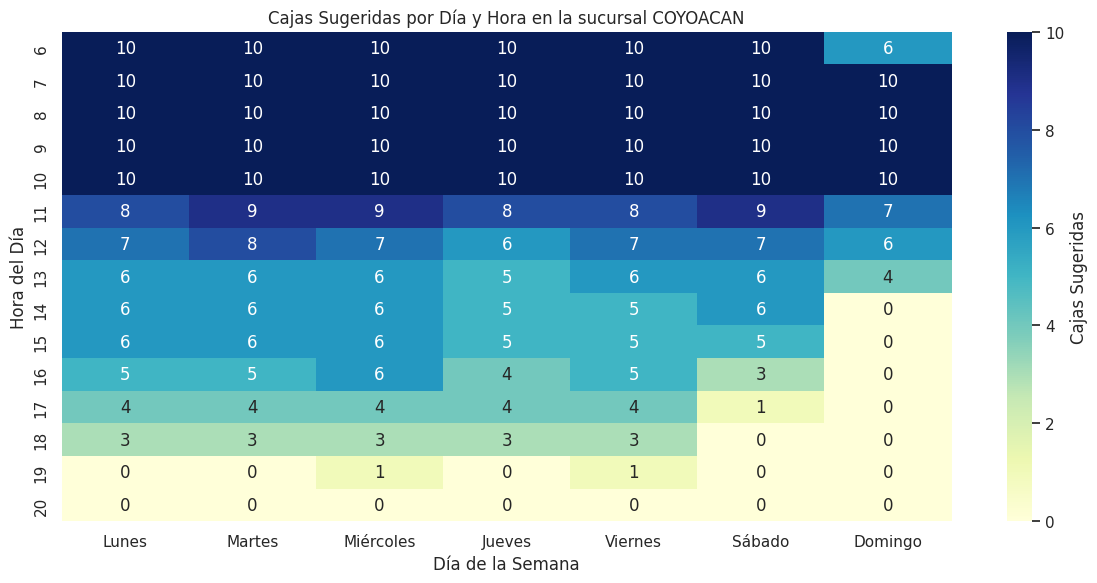

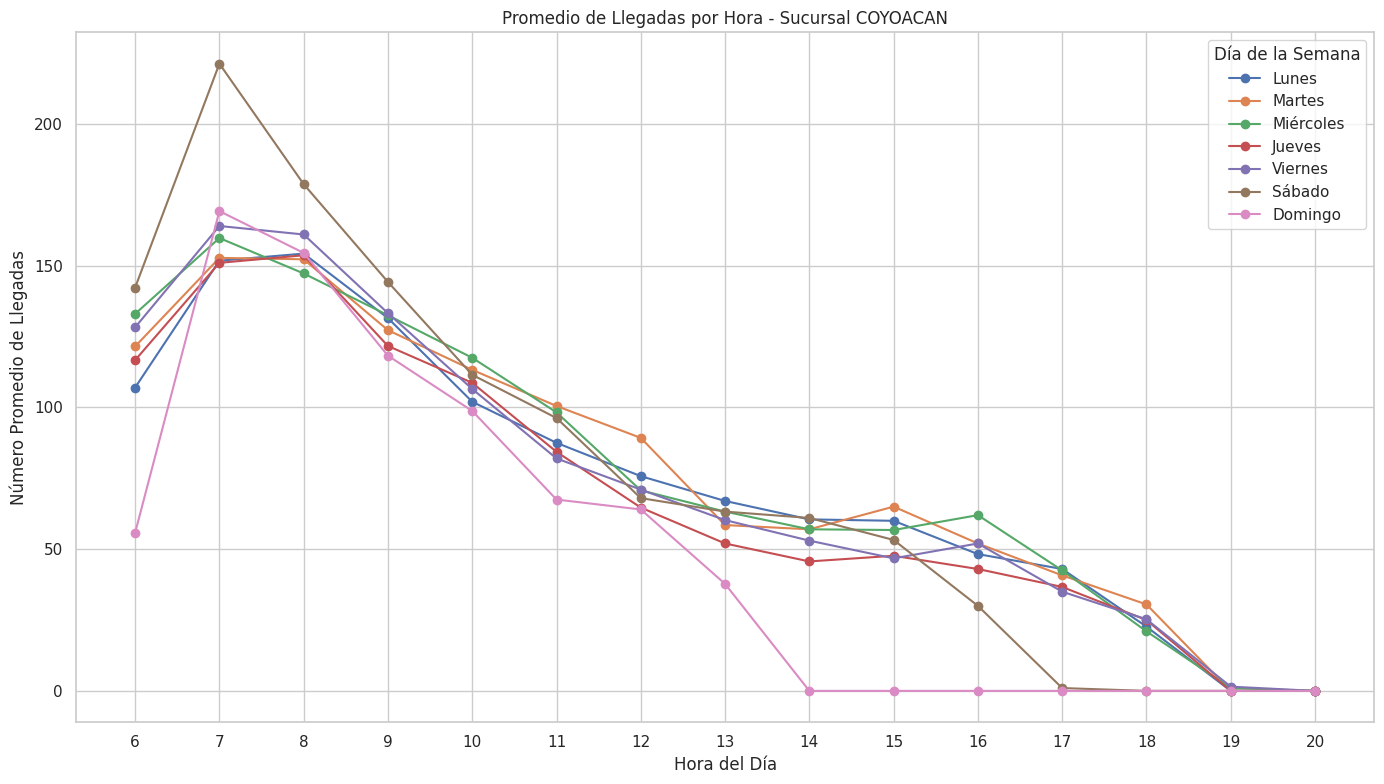

In [43]:
df_resultado_coyoacan = analisis_cajas("/content/Muestra Proyecto Socios Formadores(2).xlsx", sucursal='COYOACAN', max_cajas=10)

<ipython-input-28-87d11f0caebd>:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (máx 10)'].mean().reset_index()


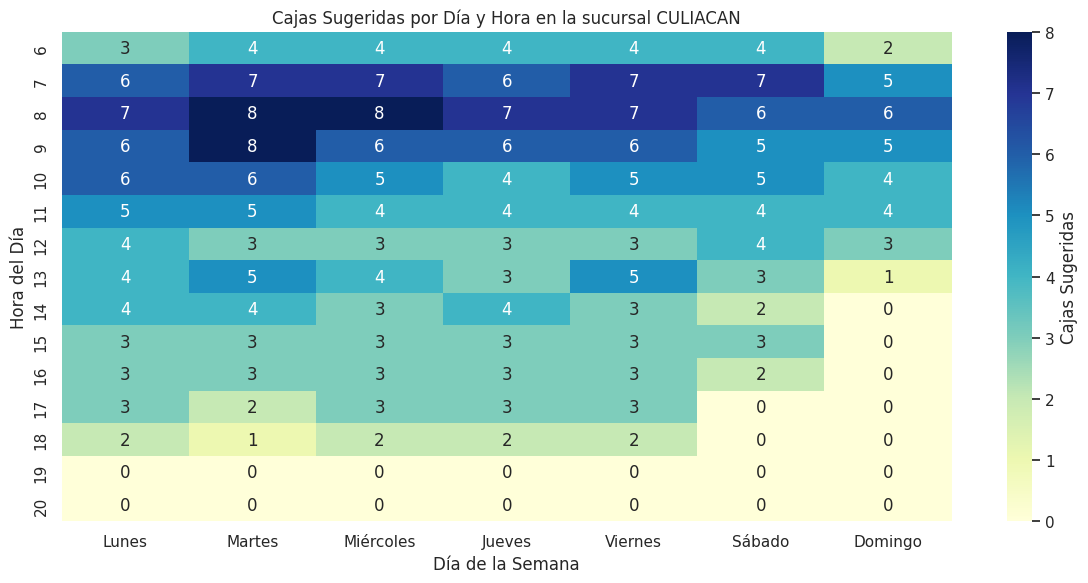

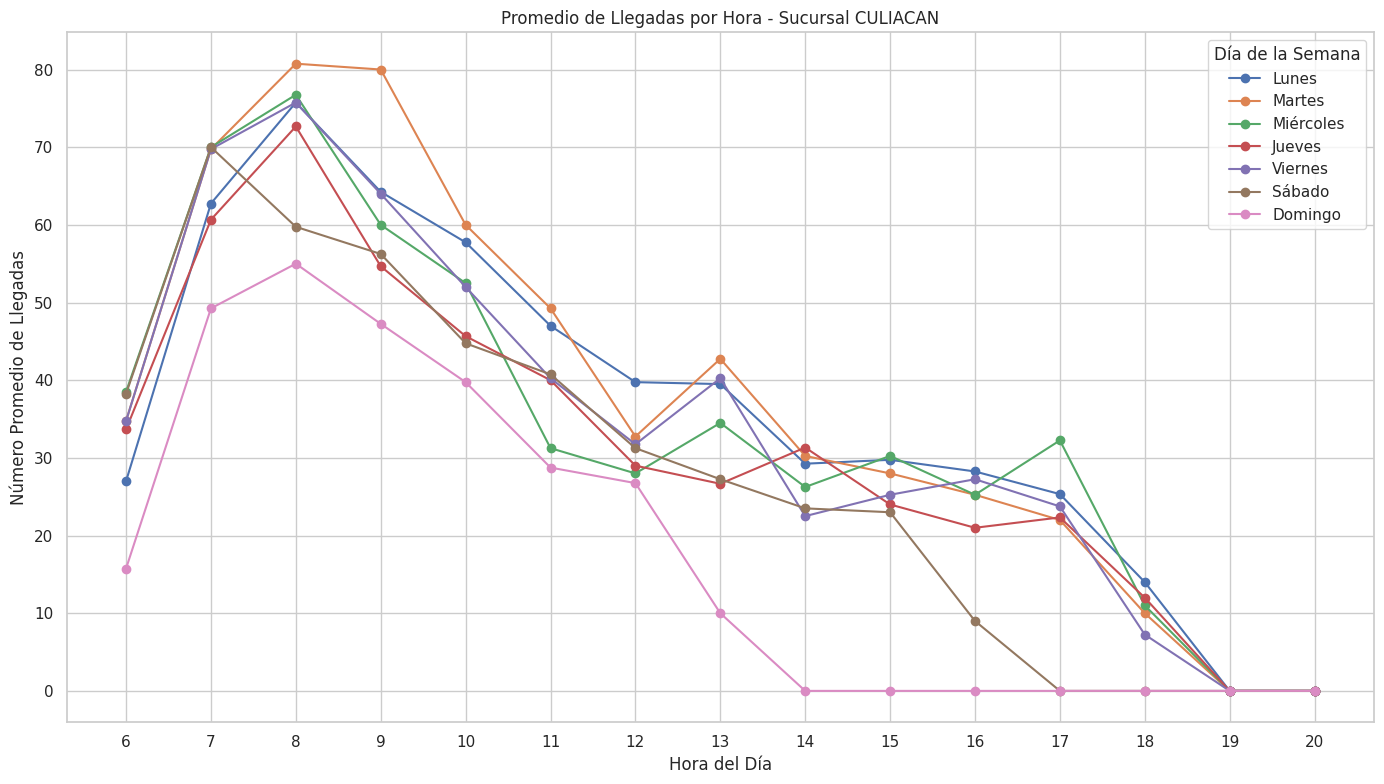

In [37]:
df_resultado_culiacan = analisis_cajas("/content/Muestra Proyecto Socios Formadores(2).xlsx", sucursal='CULIACAN', max_cajas=10)

<ipython-input-28-87d11f0caebd>:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (máx 10)'].mean().reset_index()


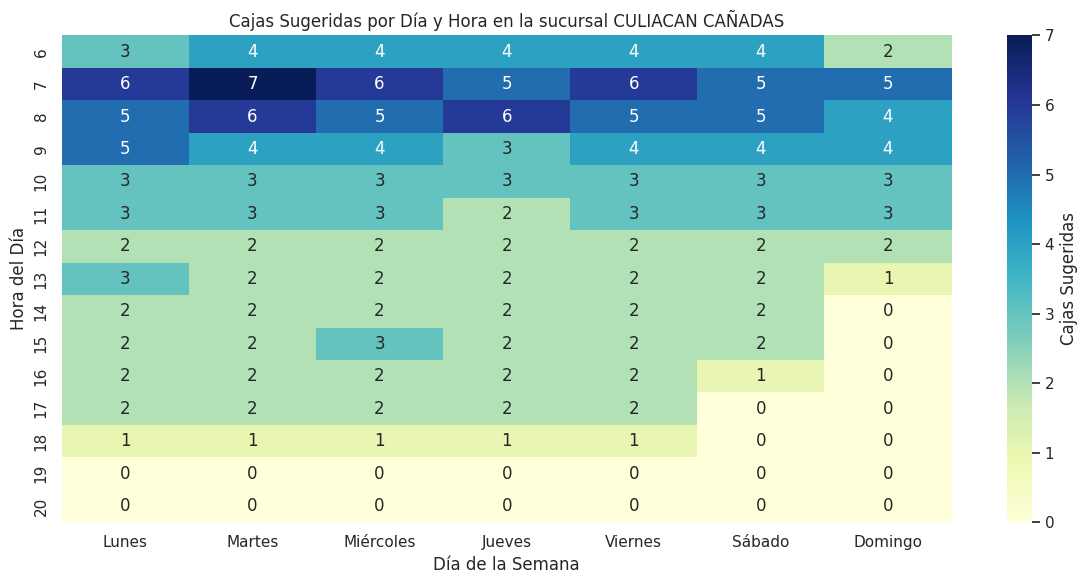

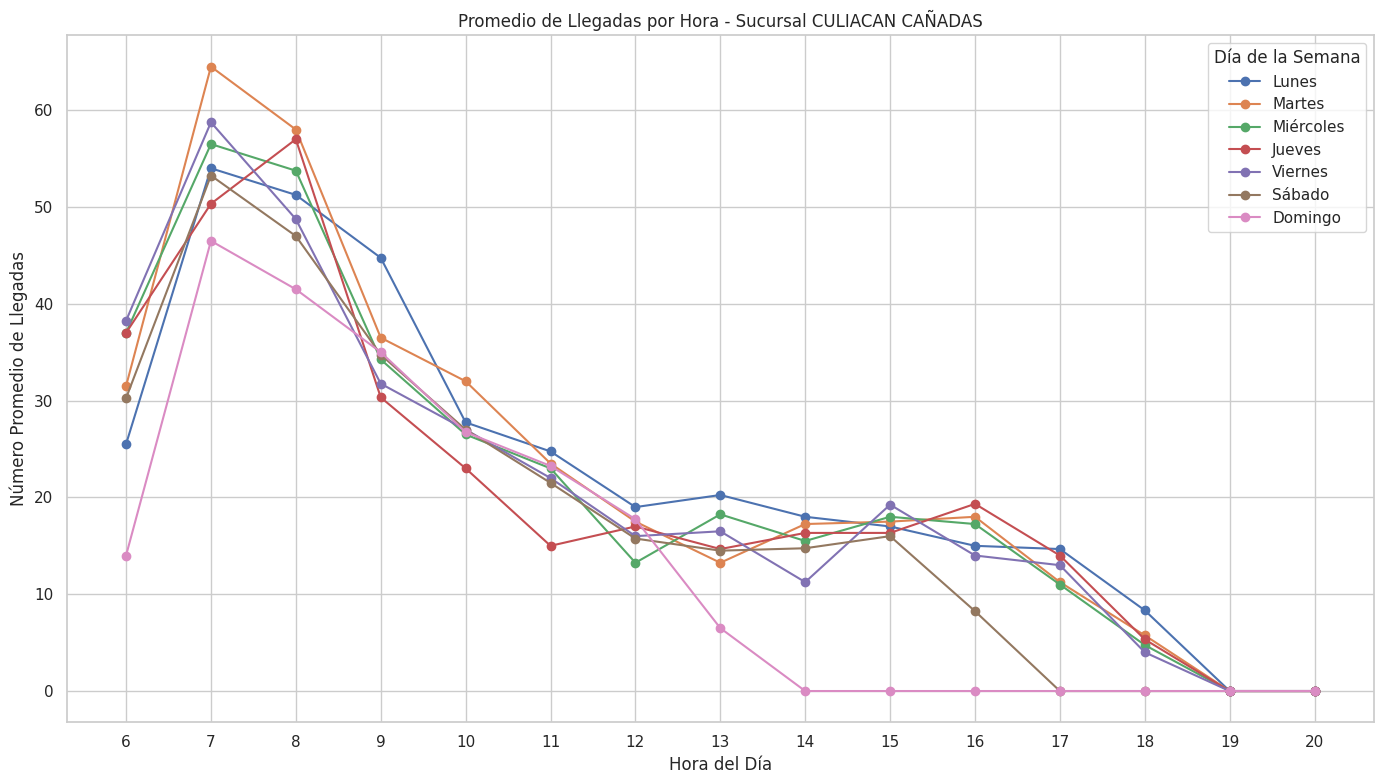

In [38]:
df_resultado_culiacan_cañadas = analisis_cajas("/content/Muestra Proyecto Socios Formadores(2).xlsx", sucursal='CULIACAN CAÑADAS', max_cajas=10)

<ipython-input-28-87d11f0caebd>:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (máx 10)'].mean().reset_index()


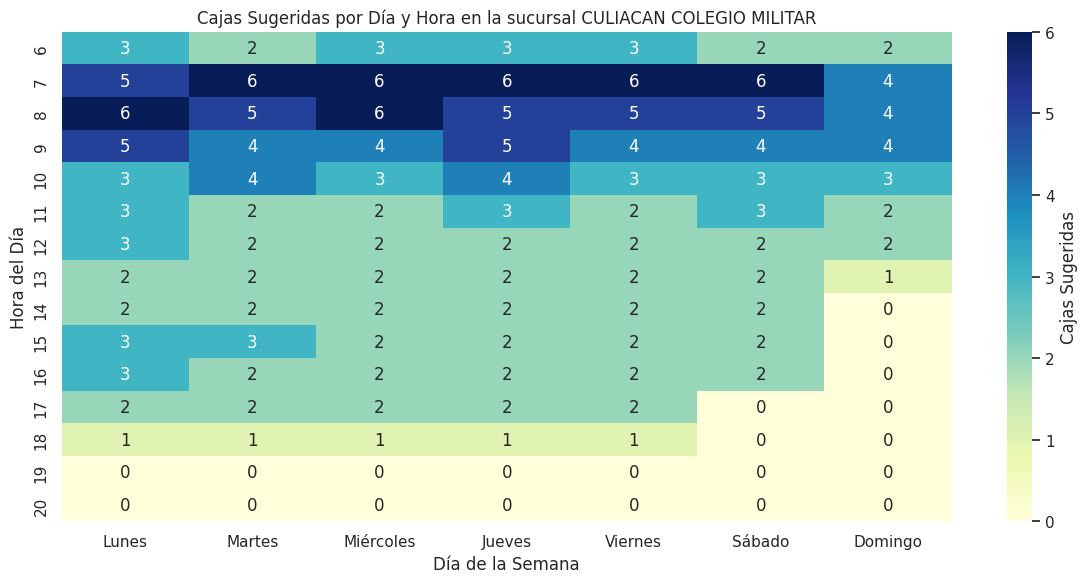

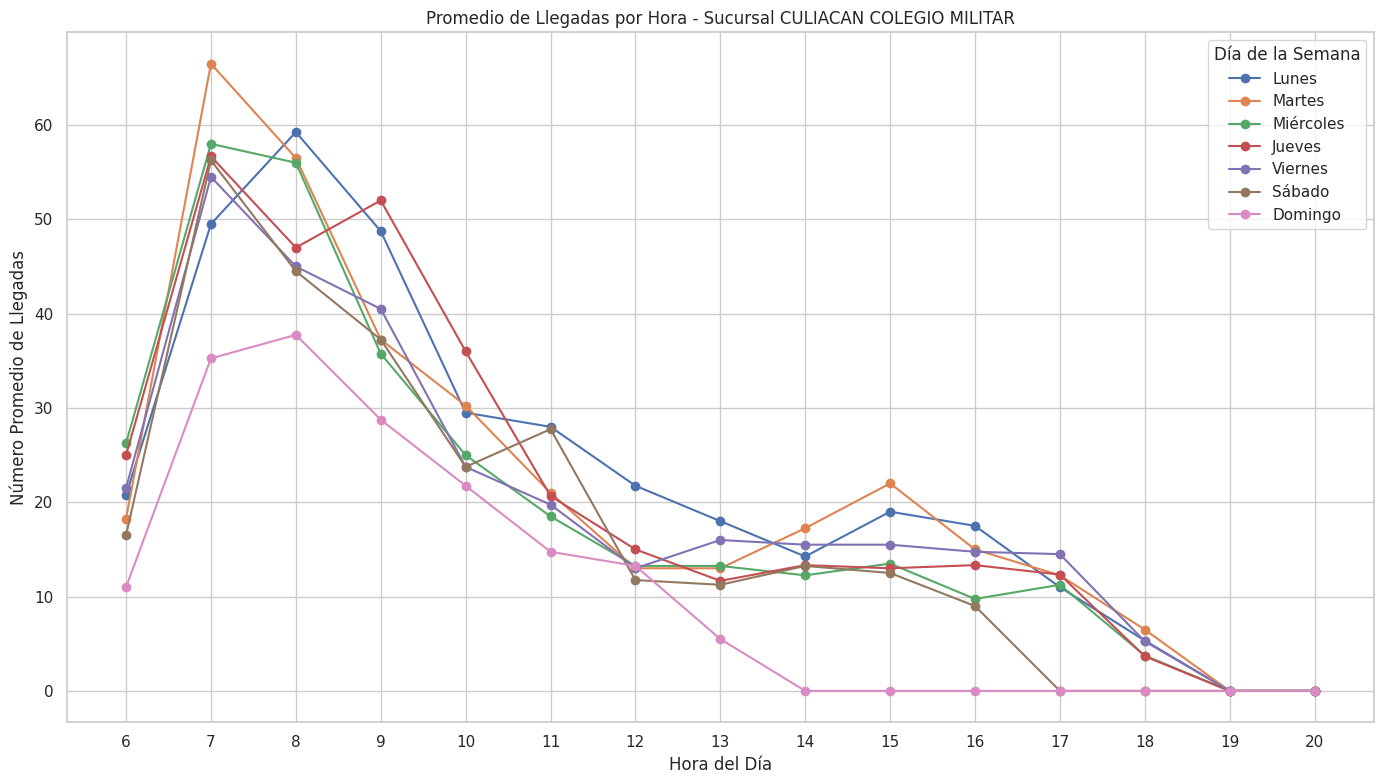

In [39]:
df_resultado_culiacan_colegio= analisis_cajas("/content/Muestra Proyecto Socios Formadores(2).xlsx", sucursal='CULIACAN COLEGIO MILITAR', max_cajas=10)

<ipython-input-28-87d11f0caebd>:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (máx 10)'].mean().reset_index()


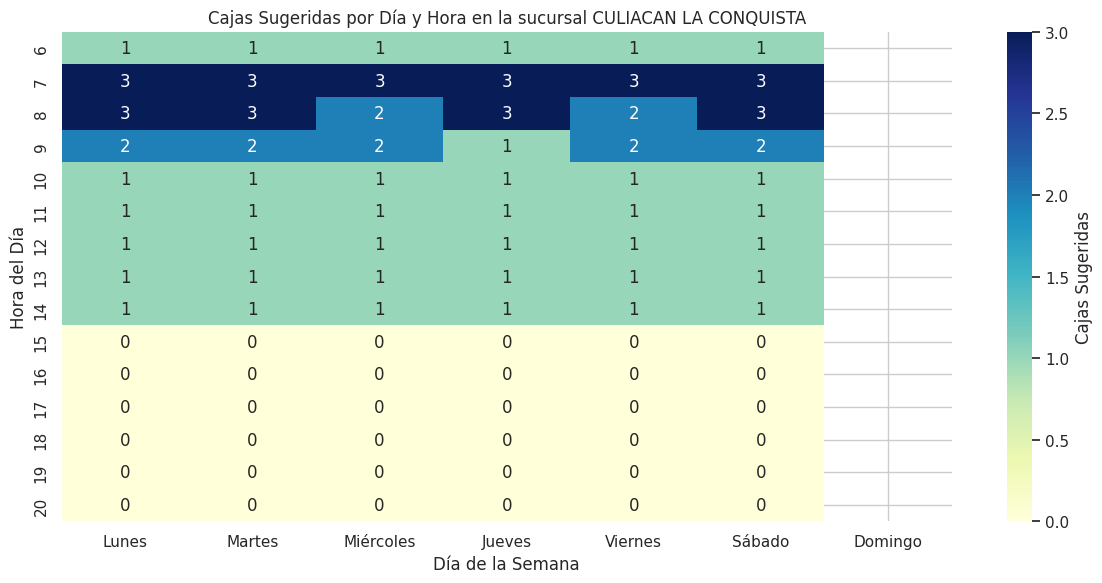

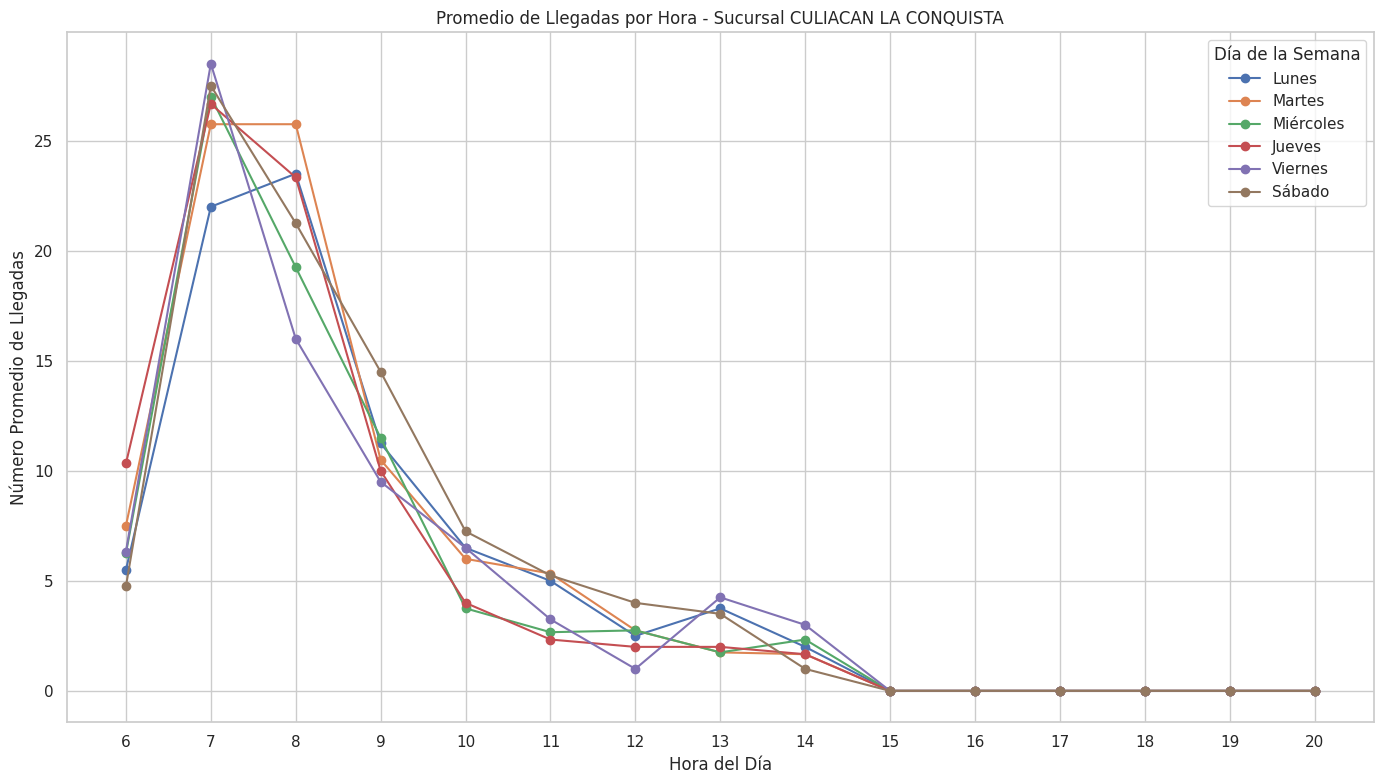

In [40]:
df_resultado_culiacan_laconquista= analisis_cajas("/content/Muestra Proyecto Socios Formadores(2).xlsx", sucursal='CULIACAN LA CONQUISTA', max_cajas=10)